In [1]:
from fastai.vision.all import *
import pandas as pd
import cam
import util

In [14]:
# Use small bs as we have very limited data due to conditional hierarchy filtering
dls, labels = util.chexpert_data_loader(use_hierarchy=True, bs=4)

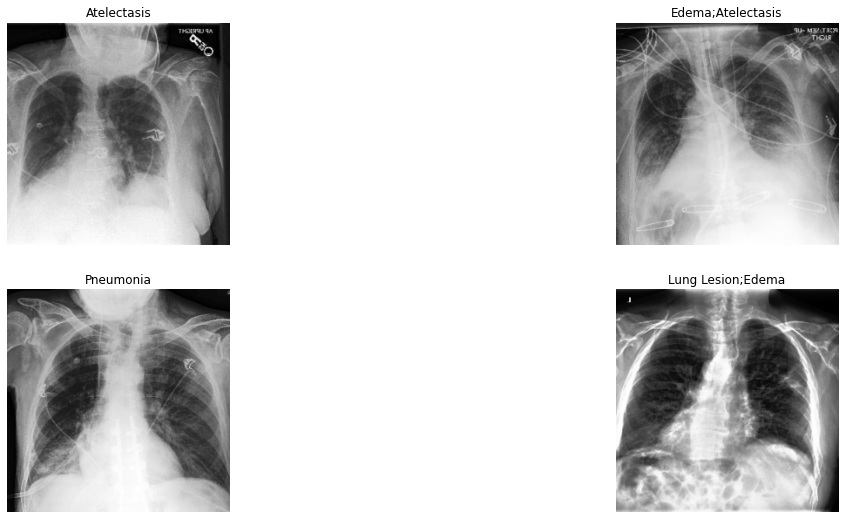

In [15]:
dls.show_batch(max_n=9, figsize=(20,9))

In [16]:
# First train on conditional probabilities
chexpert_learner_conditional = util.ChexpertLearner(dls, densenet121, n_out=len(labels),
                                        loss_func=BCEWithLogitsLossFlat(),
                                        metrics=[RocAucMulti(average=None),
                                                 RocAucMulti(average='weighted')])

lr_min/10: 0.002754228748381138, lr_steep: 6.918309736647643e-06, base_lr: 0.002754228748381138


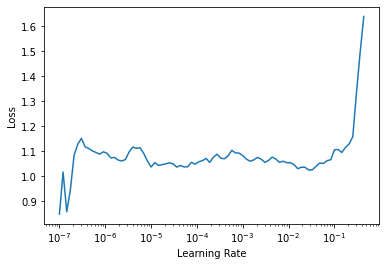

In [17]:
chexpert_learner_conditional.find_lr()

epoch,train_loss,valid_loss,roc_auc_score,roc_auc_score,time
0,0.748124,0.696497,[0.60965982 0.63455609 0.58947172 0.59058325],0.608644,01:25


Better model found at epoch 0 with valid_loss value: 0.6964965462684631.


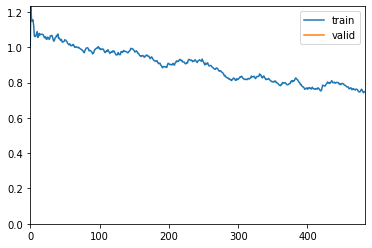

epoch,train_loss,valid_loss,roc_auc_score,roc_auc_score,time
0,0.648544,0.580142,[0.62379543 0.70919724 0.59930025 0.6177365 ],0.647399,01:42
1,0.592823,0.568643,[0.5456287 0.73822435 0.59224935 0.65042902],0.655046,01:43
2,0.605180,0.552069,[0.70091722 0.75975545 0.60589712 0.63802904],0.684607,01:43
3,0.550740,0.563109,[0.6432718 0.75084175 0.61593932 0.63636364],0.673840,01:42
4,0.555522,0.549482,[0.70059793 0.71476165 0.62037284 0.63100539],0.669046,01:43
5,0.586177,0.565854,[0.61145942 0.72000709 0.58680092 0.64565005],0.656283,01:43
6,0.541861,0.555054,[0.63468013 0.73655857 0.53418621 0.71074545],0.677941,01:43
7,0.541027,0.546442,[0.7151399 0.76700337 0.59104749 0.65386843],0.691963,01:42
8,0.542717,0.526750,[0.67537443 0.77357788 0.60394744 0.70804822],0.708109,01:43
9,0.566009,0.545378,[0.66144201 0.76413255 0.5977779 0.67676768],0.691385,01:43


Better model found at epoch 0 with valid_loss value: 0.5801421403884888.


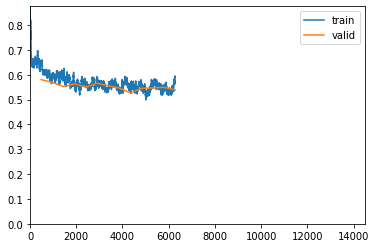

Better model found at epoch 1 with valid_loss value: 0.5686429142951965.
Better model found at epoch 2 with valid_loss value: 0.5520693063735962.
Better model found at epoch 4 with valid_loss value: 0.5494816899299622.
Epoch 6: reducing lr to 0.00012479849283919303
Better model found at epoch 7 with valid_loss value: 0.5464423894882202.
Better model found at epoch 8 with valid_loss value: 0.5267499089241028.
Epoch 10: reducing lr to 0.00013465868560620095
Epoch 12: reducing lr to 0.00012575911658957884
No improvement since epoch 8: early stopping


In [18]:
chexpert_learner_conditional.learn_model(use_saved=False, epochs=30)

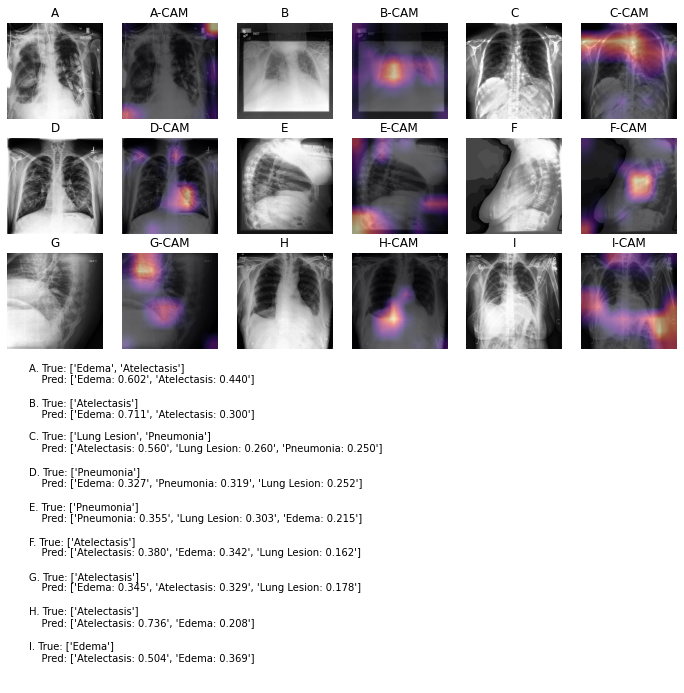

In [19]:
# Let us see how the conditional model predicts - use the saved optimal model
chexpert_learner = cnn_learner(dls, densenet121, path=Path('../saves/'))
chexpert_learner.load('densenet121-chexpert', with_opt=True)
cam.plot_cam(chexpert_learner)

In [2]:
# Reload the data as it may have been modified for conditional probs
dls, labels = util.chexpert_data_loader()

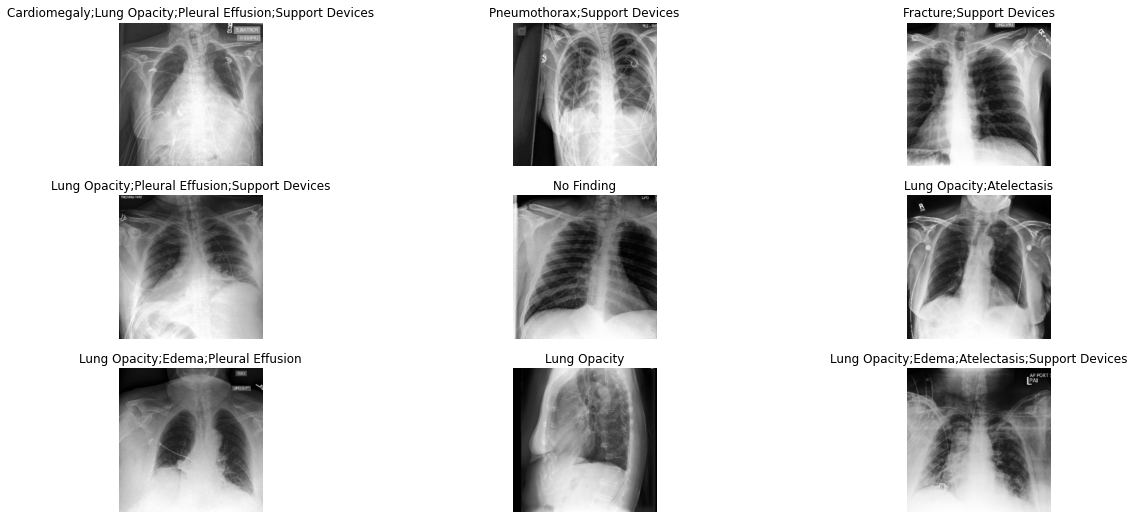

In [21]:
dls.show_batch(max_n=9, figsize=(20,9))

In [4]:
# Next train unconditionally for only transfer learning
chexpert_learner_unconditional = util.ChexpertLearner(dls, densenet121, n_out=len(labels),
                                        loss_func=BCEWithLogitsLossFlat(),
                                        metrics=[RocAucMulti(average=None),
                                                 RocAucMulti(average='weighted')])

lr_min/10: 0.014454397559165954, lr_steep: 0.04786301031708717, base_lr: 0.04786301031708717


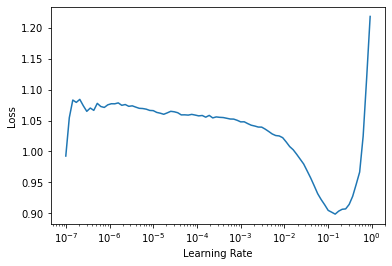

In [5]:
chexpert_learner_unconditional.find_lr()

epoch,train_loss,valid_loss,roc_auc_score,roc_auc_score,time
0,0.283537,0.282412,[0.86801897 0.65722532 0.84229599 0.72731597 0.75624263 0.83954178 0.7191589 0.74584254 0.6872435 0.84547774 0.86889869 0.7794358 0.73222392 0.8706466 ],0.807978,19:09
1,0.287369,0.280895,[0.86906072 0.6599415 0.84398637 0.7288473 0.75547031 0.8410171 0.72404429 0.74972345 0.69069764 0.85170064 0.86873709 0.79574654 0.73409859 0.87383476],0.810104,19:10
2,0.284483,0.280823,[0.86675722 0.66073334 0.84726215 0.7299723 0.76102174 0.84201031 0.72118382 0.7423808 0.68906574 0.85662279 0.86925883 0.78443803 0.73130986 0.8769761 ],0.811200,19:11
3,0.283932,0.281274,[0.867669 0.65958799 0.8461664 0.72989802 0.75580137 0.83999256 0.71794449 0.74268781 0.69168196 0.85312797 0.87042039 0.78619274 0.73487437 0.87768428],0.811224,19:01
4,0.282415,0.281872,[0.86970711 0.66265391 0.84568508 0.72911896 0.75305695 0.84080687 0.7169369 0.73945467 0.68886595 0.85791495 0.87000416 0.78764329 0.73398407 0.87812046],0.811187,19:08
5,0.287756,0.283686,[0.86760102 0.66213236 0.84219108 0.72999536 0.7539482 0.8393994 0.71237701 0.73844215 0.68940273 0.85079012 0.86842696 0.77744741 0.73221132 0.87837127],0.810271,19:10
6,0.289108,0.340266,[0.86601852 0.64150122 0.83504058 0.72524271 0.75098197 0.83916919 0.70189967 0.71851606 0.69058277 0.8518504 0.86469717 0.76307507 0.7197103 0.87656897],0.806558,19:06
7,0.293695,0.285558,[0.86333045 0.64318894 0.83735887 0.72362057 0.74493097 0.83642932 0.7172154 0.73376946 0.68865073 0.85466263 0.8695976 0.72668761 0.72486444 0.87798507],0.807460,19:15


Better model found at epoch 0 with valid_loss value: 0.28241223096847534.


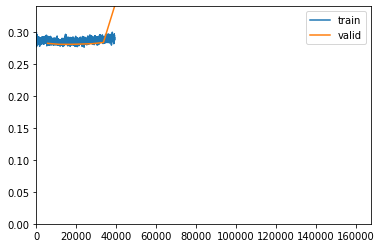

Better model found at epoch 1 with valid_loss value: 0.28089532256126404.
Better model found at epoch 2 with valid_loss value: 0.28082284331321716.
Epoch 4: reducing lr to 0.0004203150586432375
Epoch 6: reducing lr to 0.0006595532689677396
No improvement since epoch 2: early stopping


In [25]:
# Freeze the body and update the weights for the last layer
chexpert_learner_unconditional.learn_model(use_saved=True, train_saved=True, old_learner=chexpert_learner_conditional.model, epochs=0, freeze_epochs=30)

epoch,train_loss,valid_loss,roc_auc_score,roc_auc_score,time
0,0.293224,0.278501,[0.87118291 0.66187394 0.84342924 0.7311208 0.76638974 0.84541832 0.69417905 0.73677821 0.68444276 0.86273203 0.87220517 0.78876585 0.74129893 0.88583496],0.813712,28:39
1,0.291262,0.278814,[0.87110091 0.66133854 0.8431446 0.73421156 0.76998959 0.84410337 0.72010462 0.75055747 0.68668533 0.86712919 0.87774669 0.78326737 0.73306442 0.88332945],0.815649,24:36
2,0.290998,0.336358,[0.86961605 0.61392104 0.85317802 0.7306163 0.76173557 0.82849424 0.69616524 0.7219536 0.68251452 0.85762029 0.87492355 0.77329436 0.72478889 0.88667988],0.811058,24:49
3,0.297091,0.381132,[0.86176287 0.61740596 0.84183139 0.71573407 0.74077456 0.83824977 0.69398332 0.73313709 0.67647312 0.82921809 0.86985492 0.77114737 0.70566672 0.88152857],0.804023,24:52
4,0.300421,0.380436,[0.85005239 0.59647168 0.83124551 0.72388687 0.71535464 0.82813966 0.70527441 0.71313892 0.67958569 0.85403387 0.86775712 0.75803442 0.68246887 0.88310952],0.803494,24:48
5,0.302527,0.844938,[0.85160553 0.61271102 0.82637389 0.71691145 0.7336087 0.82511918 0.70260291 0.68680077 0.67441592 0.82363079 0.86776511 0.74994963 0.68366096 0.87377246],0.798209,24:47


Better model found at epoch 0 with valid_loss value: 0.2785009443759918.


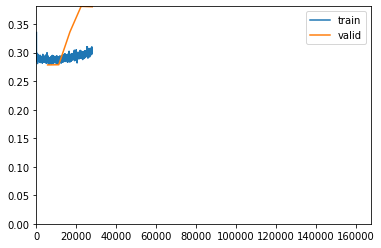

Epoch 2: reducing lr to 0.0009572084621588154
Epoch 4: reducing lr to 0.0016020579179704148
No improvement since epoch 0: early stopping


In [6]:
# Unfreeze the body and update the whole model end-to-end
chexpert_learner_unconditional.learn_model(use_saved=True, train_saved=True, epochs=30, freeze_epochs=0)

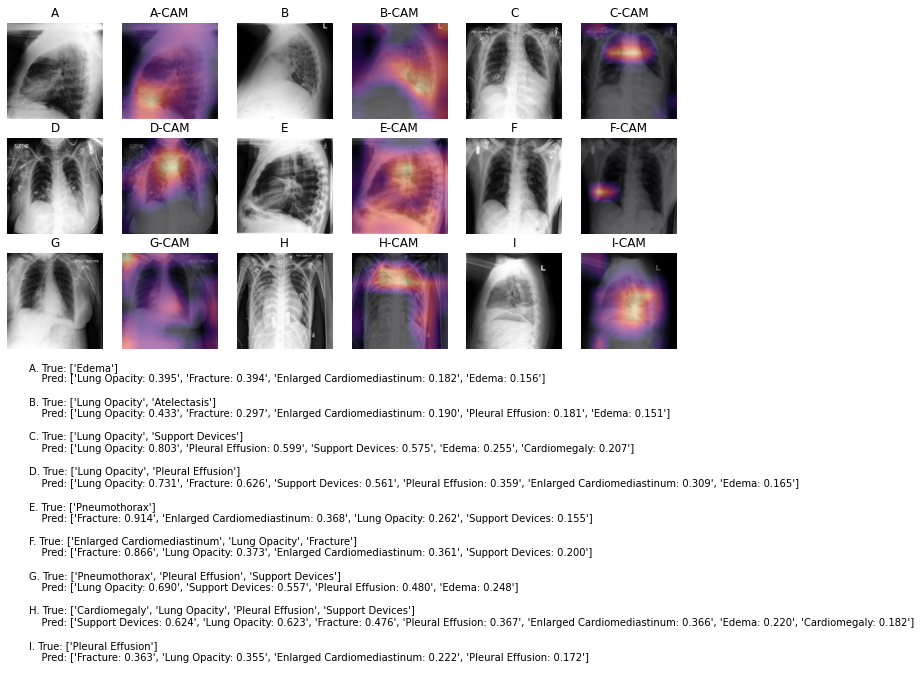

In [7]:
chexpert_learner = cnn_learner(dls, densenet121, path=Path('../saves/'))
chexpert_learner.load('densenet121-chexpert', with_opt=True)
cam.plot_cam(chexpert_learner)